# On Parcels
> An introductory article to Cryptovoxels' Parcel Data

- toc: true
- filename: Parcels
- tab: CVMinigames | Parcels
- title: CVMinigames
- template: article
- description: this isnt working
- image: images/company_logo.png
- keywords: thisworks
- badges: true
- comments: true
- categories: [test]
- hide: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

Lets explore voxels data!

## Parcel Data

In [ ]:
#hide 
!pip install matplotlib  
!pip install requests

For starters CV provides generic data on ALL their [parcels](https://www.cryptovoxels.com/api/parcels/search.json).

In [6]:
#hide 
import requests
import pandas as pd
import json
url = 'https://www.cryptovoxels.com/api/parcels/search.json'
r = requests.get(url)
data = json.loads(r.text)['parcels'] 
parcels = pd.DataFrame.from_dict(data)
parcels.head(1)

,id,height,address,suburb,island,name,geometry,area,distance_to_center,distance_to_ocean,...,owner,owner_name,x1,x2,y1,label,y2,z1,z2,hash
0,7828,10,2b Buttery Boulevard,Strawberry Sands,Pastel,None,"{'type': 'Polygon', 'crs': {'type': 'name', 'p...",160,4753.79,10.65,...,0xa253d7cd38dc2d0b2e65ad42a7e4beb3c60a83ad,crvox.eth,-2751,-2741,8,None,10,3884,3900,b8c069daf68f1111eb07787db55187c9b5c77f77


In [127]:
#hide 
rdf = parcels[['id','island','suburb','area','height', 'owner_name']].copy()
rdf['vol'] = rdf['height'] * rdf['area']
rdf['vol_heightPlusFive'] = (rdf['height'] +5) * rdf['area']
rdf = rdf.sort_values('vol_heightPlusFive', ascending=False)
rdf = rdf.reset_index()
rdf = rdf[rdf['owner_name'] != 'crvox.eth']
rdf = rdf[rdf['owner_name'] != 'bnolan']

The data contains geocoordinates and a bit of meta data which can let us do fun stuff like creating this <a href="https://cvminigames.com/blog/docs/maps/cv_price_map.html"> map </a>.

We can do other things. 

Here is a frequency plot of Islands by parcel size and also a box and whiskers of that same data

array([<AxesSubplot:title={'center':'vol_heightPlusFive'}, xlabel='[island, suburb]'>,
       <AxesSubplot:>], dtype=object)

C:\Users\carlos\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23487 (\N{CJK UNIFIED IDEOGRAPH-5BBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50872 (\N{

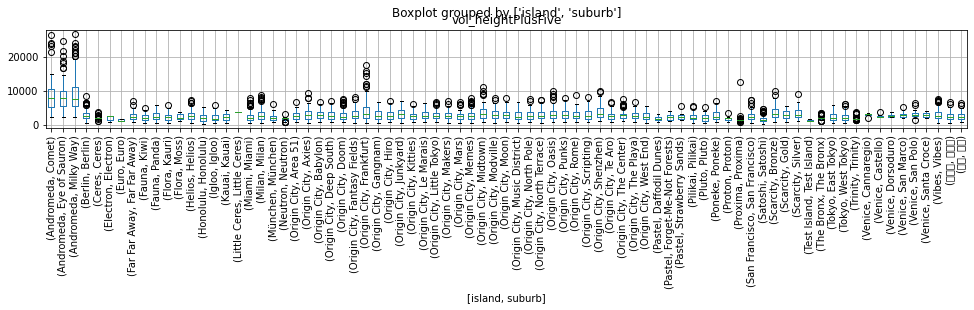

In [129]:
#hide_input 
rdf.boxplot(column=['vol_heightPlusFive'], by=['island', 'suburb'], rot=90, figsize=(16,4), layout=(2, 1))

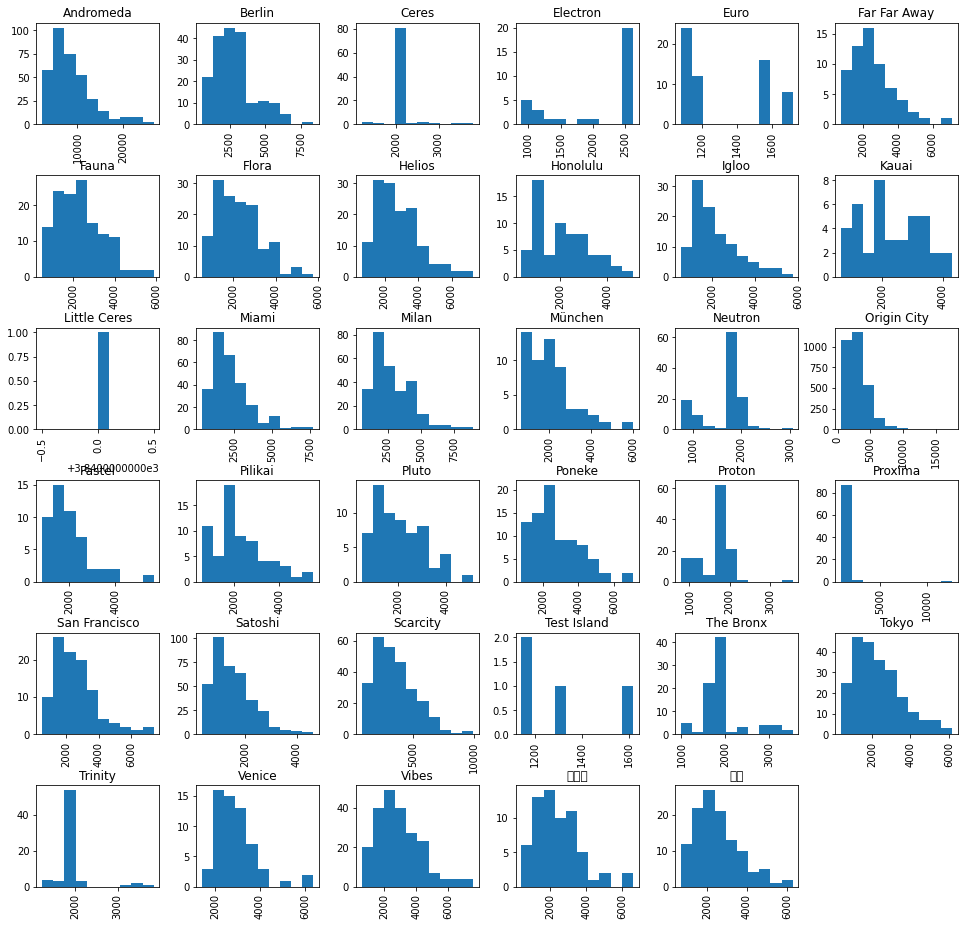

In [132]:
#hide_input 
rdf.hist(by=['island'], column = 'vol_heightPlusFive', figsize=(16,16))
plt.show()

In [136]:
%%capture
!pip install pivottablejs

In [139]:
#hide_input 
# https://github.com/JasonKessler/scattertext
# https://colab.research.google.com/drive/1VIMd9jhpNgB9siYlTSFqjV62mMQQFx4K

from pivottablejs import pivot_ui
from IPython.display import HTML
#if using locally you can just use the following to display the output: pivot_ui(df)
# As we are using colab, we will just download the output - this can then be opened in a new tab in the browser

import IPython

pivot_ui( rdf, outfile_path='../docs/tables/parcelsPivotTable.html')
IPython.display.HTML(filename='../docs/tables/parcelsPivotTable.html')

The information explored this far can be interactively explored [here](https://cvminigames.com/blog/docs/tables/parcelsPivotTable.html)

## Filtering Parcels

Information about a specific parcel is available by adding it's parcel number + .json to the end of the following url: https://www.cryptovoxels.com/api/parcels/  

This data can then be filtered en-mass to search for certain properties, or inspected individually.

For example, here is a [map](https://cvminigames.com/blog/docs/maps/cv_book_map.html) of all the guestbooks!